

## Santander consumer prediction

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from catboost import CatBoostClassifier,Pool
from IPython.display import display
import matplotlib.patches as patch
import matplotlib.pyplot as plt
from sklearn.svm import NuSVR
from scipy.stats import norm
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time
import glob
import sys
import os
import gc

In [47]:
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 15)

### Import and see data

In [48]:
train= pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [49]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [50]:
train.shape, test.shape, sample_submission.shape

((200000, 202), (200000, 201), (200000, 2))

In [51]:
train.head(5)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.925500000000000,-6.7863,11.908099999999999,5.093000000000000,11.460699999999999,-9.2834,5.1187,18.626600000000000,...,4.4354,3.9642,3.1364,1.691000000000000,18.522700000000000,-2.3978,7.8784,8.563499999999999,12.780300000000000,-1.091400000000000
1,train_1,0,11.500600000000000,-4.1473,13.858800000000000,5.388999999999999,12.362200000000000,7.0433,5.6208,16.533799999999999,...,7.6421,7.7214,2.5837,10.951599999999999,15.430500000000000,2.0339,8.1267,8.788900000000000,18.355999999999998,1.951800000000000
2,train_2,0,8.609299999999999,-2.7457,12.080500000000001,7.892800000000000,10.582500000000000,-9.0837,6.9427,14.615500000000001,...,2.9057,9.7905,1.6704,1.685800000000000,21.604199999999999,3.1417,-6.5213,8.267500000000000,14.722200000000001,0.396500000000000
3,train_3,0,11.060400000000000,-2.1518,8.952199999999999,7.195700000000000,12.584600000000000,-1.8361,5.8428,14.925000000000001,...,4.4666,4.7433,0.7178,1.421400000000000,23.034700000000001,-1.2706,-2.9275,10.292199999999999,17.969700000000000,-8.999599999999999
4,train_4,0,9.836900000000000,-1.4834,12.874599999999999,6.637500000000000,12.277200000000001,2.4486,5.9405,19.251400000000000,...,-1.4905,9.5214,-0.1508,9.194200000000000,13.287599999999999,-1.5121,3.9267,9.503100000000000,17.997399999999999,-8.810400000000000


In [52]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.953600000000000,9.4292,11.432700000000001,-2.380500000000000,5.8493,18.267499999999998,2.1337,...,-2.1556,11.849500000000001,-1.4300,2.4508,13.711200000000000,2.4669,4.3654,10.720000000000001,15.472200000000001,-8.719700000000000
1,test_1,8.5304,1.2543,11.304700000000000,5.1858,9.197400000000000,-4.011700000000000,6.0196,18.631599999999999,-4.4131,...,10.6165,8.834899999999999,0.9403,10.1282,15.576499999999999,0.4773,-1.4852,9.871400000000000,19.129300000000001,-20.975999999999999
2,test_2,5.4827,-10.3581,10.140700000000001,7.0479,10.262800000000000,9.805199999999999,4.8950,20.253699999999998,1.5233,...,-0.7484,10.993499999999999,1.9803,2.1800,12.981299999999999,2.1281,-7.1086,7.061800000000000,19.895600000000002,-23.179400000000001
3,test_3,8.5374,-1.3222,12.022000000000000,6.5749,8.845800000000001,3.174400000000000,4.9397,20.565999999999999,3.3755,...,9.5702,9.076599999999999,1.6580,3.5813,15.187400000000000,3.1656,3.9567,9.229500000000000,13.016800000000000,-4.210800000000000
4,test_4,11.7058,-0.1327,14.129500000000000,7.7506,9.103500000000000,-8.584800000000000,6.8595,10.604799999999999,2.9890,...,4.2259,9.172300000000000,1.2835,3.3778,19.554200000000002,-0.2860,-5.1612,7.288200000000000,13.925999999999998,-9.184600000000000


In [53]:
train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [54]:
print(len(train.columns))

202


In [10]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB
None


In [11]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,...,200000.000000000000000,200000.000000000000000,200000.00000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000
mean,0.100490000000000,10.679914252000151,-1.627621689499992,10.715191851000073,6.796529157000018,11.078333240500118,-5.065317493499968,5.408948681499958,16.545849889500108,0.284161849999996,...,3.234439775999965,7.438408337000044,1.92783851400003,3.331773684500021,17.993784182999992,-0.142088433500005,2.303335243500019,8.908157683499990,15.870720248000522,-3.326536900499999
std,0.300652975806355,3.040050870668801,4.050044189955011,2.640894191799927,2.043319016359718,1.623149533936866,7.863266683476754,0.866607266216908,3.418075578937139,3.332633536717585,...,4.559921679910722,3.023271794723963,1.47842289233660,3.992030367901846,3.135161996426620,1.429372364408401,5.454369250069321,0.921625484493855,3.010945491221765,10.438015107352546
min,0.000000000000000,0.408400000000000,-15.043400000000000,2.117100000000000,-0.040200000000000,5.074800000000000,-32.562600000000003,2.347300000000000,5.349700000000000,-10.505500000000000,...,-14.093299999999999,-2.691700000000000,-3.81450000000000,-11.783400000000000,8.694400000000000,-5.261000000000000,-14.209600000000000,5.960600000000000,6.299300000000000,-38.852800000000002
25%,0.000000000000000,8.453850000000001,-4.740025000000000,8.722474999999999,5.254075000000000,9.883175000000000,-11.200350000000000,4.767700000000000,13.943800000000000,-2.317800000000000,...,-0.058825000000000,5.157400000000000,0.88977500000000,0.584600000000000,15.629799999999999,-1.170700000000000,-1.946925000000000,8.252800000000001,13.829700000000001,-11.208475000000000
50%,0.000000000000000,10.524750000000001,-1.608050000000000,10.580000000000000,6.825000000000000,11.108250000000000,-4.833150000000000,5.385100000000000,16.456800000000001,0.393700000000000,...,3.203600000000000,7.347750000000000,1.90130000000000,3.396350000000000,17.957949999999997,-0.172700000000000,2.408900000000000,8.888199999999999,15.934050000000001,-2.819550000000000
75%,0.000000000000000,12.758200000000000,1.358625000000000,12.516700000000000,8.324100000000000,12.261125000000002,0.924800000000000,6.002999999999999,19.102900000000002,2.937900000000000,...,6.406200000000000,9.512525000000000,2.94950000000000,6.205800000000000,20.396524999999997,0.829600000000000,6.556725000000000,9.593299999999999,18.064724999999999,4.836800000000000
max,1.000000000000000,20.315000000000001,10.376799999999999,19.352999999999998,13.188300000000000,16.671399999999998,17.251600000000000,8.447699999999999,27.691800000000001,10.151300000000001,...,18.440899999999999,16.716500000000000,8.40240000000000,18.281800000000000,27.928799999999999,4.272900000000000,18.321500000000000,12.000400000000001,26.079100000000000,28.500699999999998


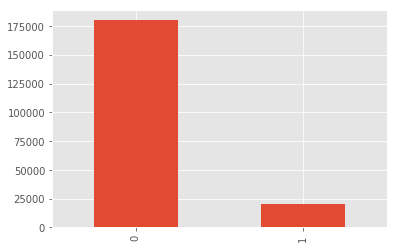

In [12]:
train['target'].value_counts().plot.bar();

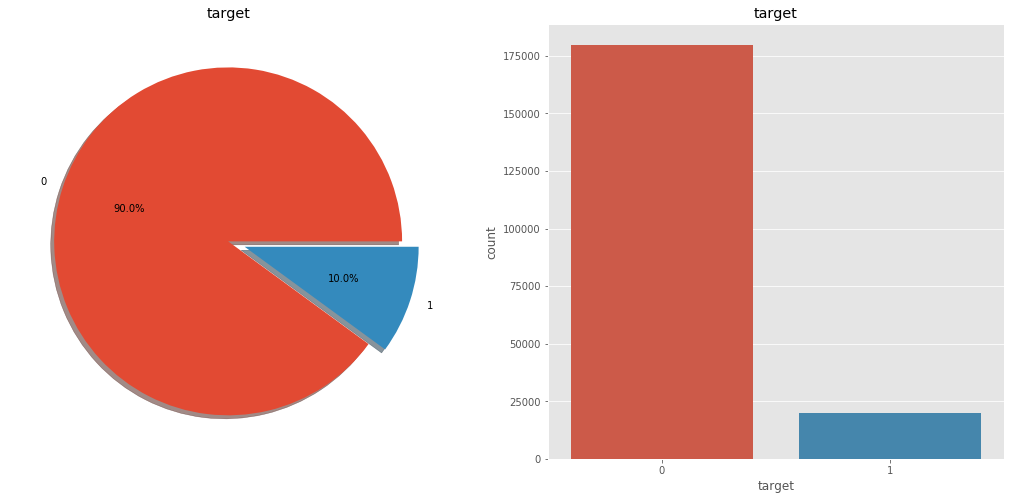

In [13]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('target')
ax[0].set_ylabel('')
sns.countplot('target',data=train,ax=ax[1])
ax[1].set_title('target')
plt.show()

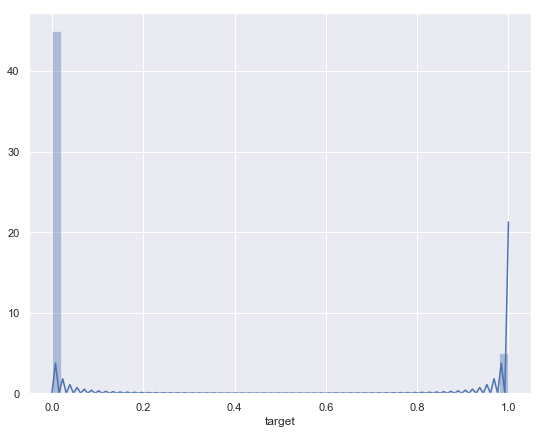

In [55]:
sns.set(rc={'figure.figsize':(9,7)})
sns.distplot(train['target']);

### Correlations

In [56]:
corr_matrix = train.corr().abs()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))


In [57]:
sol

target   var_81     0.080917332274474
         var_139    0.074079632741530
         var_12     0.069489282496313
         var_6      0.066730845612682
         var_110    0.064275298890945
         var_146    0.063643883477175
         var_53     0.063398609142233
         var_26     0.062422192885953
         var_76     0.061917465913838
         var_174    0.061669067593984
         var_22     0.060558424722052
         var_21     0.058482738148866
         var_99     0.058367016049368
         var_166    0.057773032604770
         var_80     0.057609481138156
         var_190    0.055973414012969
         var_2      0.055870347841849
         var_165    0.055733787527844
         var_13     0.055156277483637
         var_148    0.055011090526536
         var_133    0.054547620919939
         var_198    0.052999641368535
         var_34     0.052692106739618
         var_0      0.052389591771380
         var_1      0.050342628834231
         var_115    0.050174237220934
         var

In [58]:
train.corr().unstack().sort_values().drop_duplicates()

target   var_81    -0.080917332274474
var_139  target    -0.074079632741530
target   var_12    -0.069489282496313
var_146  target    -0.063643883477175
var_76   target    -0.061917465913838
var_174  target    -0.061669067593984
var_21   target    -0.058482738148866
target   var_166   -0.057773032604770
var_80   target    -0.057609481138156
target   var_165   -0.055733787527844
         var_13    -0.055156277483637
         var_148   -0.055011090526536
         var_198   -0.052999641368535
         var_34    -0.052692106739618
var_115  target    -0.050174237220934
target   var_109   -0.049926000045858
var_44   target    -0.049039389610659
target   var_169   -0.048382176132146
         var_149   -0.047319078920154
var_92   target    -0.046295264840698
var_154  target    -0.046106039917207
target   var_108   -0.044791155673611
         var_33    -0.044333933503689
var_192  target    -0.042858399358765
target   var_9     -0.042805499596589
         var_122   -0.042461061434467
         var

In [ ]:
def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    print(df.sort_values(by='corr',ascending=False))
corrank(train) # prints a descending list of correlation pair (Max on top)

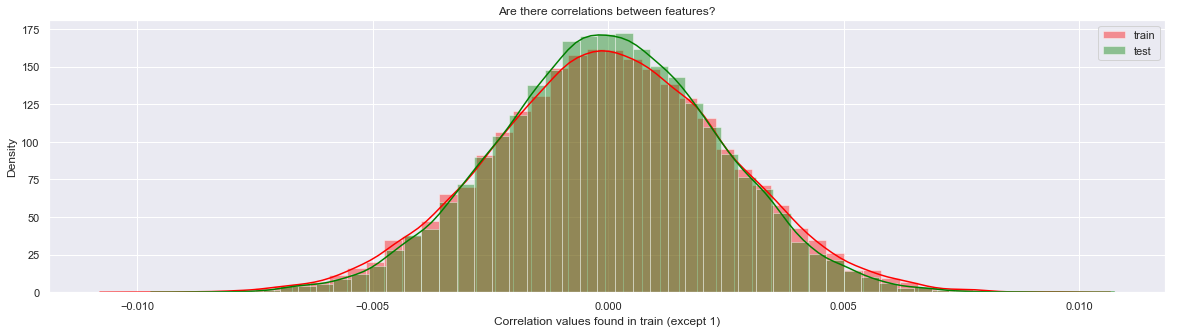

In [59]:
train_correlations = train.drop(["target"], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Red", label="train")
sns.distplot(test_correlations, color="Green", label="test")
plt.xlabel("Correlation values found in train (except 1)")
plt.ylabel("Density")
plt.title("Are there correlations between features?"); 
plt.legend();



### Check missing data

In [60]:
train.isnull().sum().sum()

0

In [61]:
for column in train:
    if train[column].isnull().any():
        print('{0} has {1} null values'.format(column, train[column].isnull().sum()))

In [62]:
test.isnull().sum().sum()

0

### Deal with imbalance 

In [63]:
train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [64]:
def check_balance(df,target):
    check=[]
    # written by MJ Bahmani for binary target
    print('size of data is:',df.shape[0] )
    for i in [0,1]:
        print('for target  {} ='.format(i))
        print(df[target].value_counts()[i]/df.shape[0]*100,'%')

In [65]:
check_balance(train,'target')

size of data is: 200000
for target  0 =
89.95100000000001 %
for target  1 =
10.049 %


In [66]:
print("Skewness: %f" % train['target'].skew())
print("Kurtosis: %f" % train['target'].kurt())

Skewness: 2.657642
Kurtosis: 5.063112


### PCA

In [67]:
target = train['target']
train = train.drop(["ID_code", "target"], axis=1)

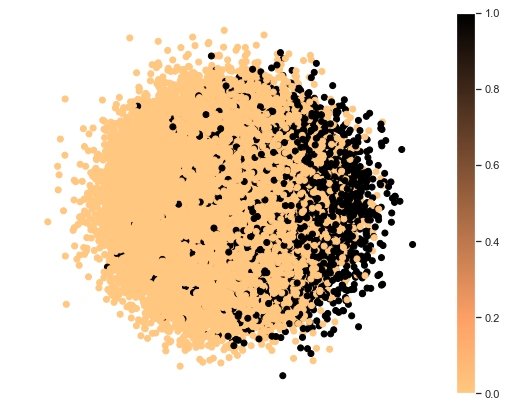

In [68]:
from sklearn.decomposition import PCA









from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)         
PCA_train_x = PCA(2).fit_transform(train_scaled)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

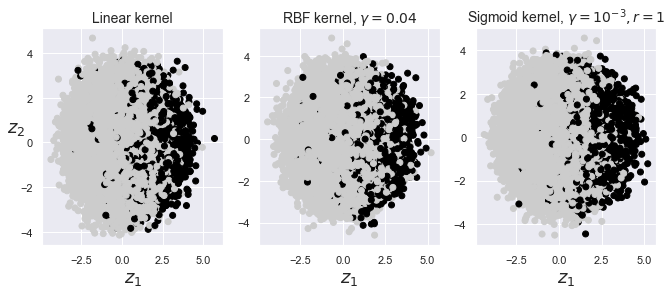

In [69]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    PCA_train_x = PCA(2).fit_transform(train_scaled)
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="nipy_spectral_r")
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

### Explainability 

In [74]:
#cols=["target","ID_code"]
#X = train.drop(cols,axis=1)
#y = train["target"]
X=train
y=target

In [75]:
X_test  = test.drop("ID_code",axis=1)

In [76]:
#calculate which feature are more important.
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [77]:
import eli5
from eli5.sklearn import PermutationImportance

In [78]:
perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)

In [79]:
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=150)

Weight,Feature
0.0002 ± 0.0002,var_110
0.0001 ± 0.0001,var_157
0.0001 ± 0.0001,var_162
0.0001 ± 0.0001,var_42
0.0001 ± 0.0002,var_170
0.0001 ± 0.0002,var_174
0.0001 ± 0.0001,var_188
0.0001 ± 0.0001,var_147
0.0001 ± 0.0001,var_197
0.0001 ± 0.0001,var_47


In [80]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

In [81]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]

In [82]:
from sklearn import tree
import graphviz
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=features)

In [83]:
#graphviz.Source(tree_graph)

In [ ]:
from matplotlib import pyplot as plt
import pdpbox
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
 #pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_81')

# plot it
 #pdp.pdp_plot(pdp_goals, 'var_81')
 #plt.show()

In [92]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_82')

# plot it
pdp.pdp_plot(pdp_goals, 'var_82')
plt.show()

NameError: name 'pdp' is not defined

In [93]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_139')

# plot it
pdp.pdp_plot(pdp_goals, 'var_139')
plt.show()

NameError: name 'pdp' is not defined

In [ ]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_110')

# plot it
pdp.pdp_plot(pdp_goals, 'var_110')
plt.show()

In [94]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


rfc_model.predict_proba(data_for_prediction_array);

In [95]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rfc_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [96]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

### Other models  

In [97]:
params = {'objective' : "binary", 
               'boost':"gbdt",
               'metric':"auc",
               'boost_from_average':"false",
               'num_threads':8,
               'learning_rate' : 0.01,
               'num_leaves' : 13,
               'max_depth':-1,
               'tree_learner' : "serial",
               'feature_fraction' : 0.05,
               'bagging_freq' : 5,
               'bagging_fraction' : 0.4,
               'min_data_in_leaf' : 80,
               'min_sum_hessian_in_leaf' : 10.0,
               'verbosity' : 1}

In [98]:
# for get better result chage fold_n to 5
fold_n=5
folds = StratifiedKFold(n_splits=fold_n, shuffle=True, random_state=10)


In [99]:
%%time
y_pred_lgb = np.zeros(len(X_test))
num_round = 1000
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(params,train_data,num_round,#change 20 to 2000
                    valid_sets = [train_data, valid_data],verbose_eval=1000,early_stopping_rounds = 3500)##change 10 to 200
            
    y_pred_lgb += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)/5

Fold 0 started at Wed May 15 22:07:46 2019
Training until validation scores don't improve for 3500 rounds.
[1000]	training's auc: 0.901253	valid_1's auc: 0.878516
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.901253	valid_1's auc: 0.878516
Fold 1 started at Wed May 15 22:08:19 2019
Training until validation scores don't improve for 3500 rounds.
[1000]	training's auc: 0.900252	valid_1's auc: 0.885857
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.900252	valid_1's auc: 0.885857
Fold 2 started at Wed May 15 22:08:51 2019
Training until validation scores don't improve for 3500 rounds.
[1000]	training's auc: 0.900684	valid_1's auc: 0.882368
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.900684	valid_1's auc: 0.882368
Fold 3 started at Wed May 15 22:09:25 2019
Training until validation scores don't improve for 3500 rounds.
[1000]	training's auc: 0.901032	valid_1's auc: 0.882603
Did not meet early stopping. Best it

In [100]:
y_pred_rfc = rfc_model.predict(X_test)

In [101]:
y_pred_tree = tree_model.predict(X_test)

In [102]:
train_pool = Pool(train_X,train_y)
cat_model = CatBoostClassifier(
                               iterations=3000,# change 25 to 3000 to get best performance 
                               learning_rate=0.03,
                               objective="Logloss",
                               eval_metric='AUC',
                              )
cat_model.fit(train_X,train_y,silent=True)
y_pred_cat = cat_model.predict(X_test)

KeyboardInterrupt: 

### Submissions

In [ ]:
submission_rfc = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_rfc
    })
submission_rfc.to_csv('submission_rfc.csv', index=False)

In [ ]:
submission_tree = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_tree
    })
submission_tree.to_csv('submission_tree.csv', index=False)

In [ ]:
submission_cat = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_cat
    })
submission_cat.to_csv('submission_cat.csv', index=False)

In [ ]:
submission_lgb = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_lgb
    })
submission_lgb.to_csv('submission_lgb.csv', index=False)

### Combine models

In [ ]:
submission_rfc_cat = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": (y_pred_rfc +y_pred_cat)/2
    })
submission_rfc_cat.to_csv('submission_rfc_cat.csv', index=False)

In [ ]:
submission_lgb_cat = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": (y_pred_lgb +y_pred_cat)/2
    })
submission_lgb_cat.to_csv('submission_lgb_cat.csv', index=False)


In [ ]:
submission_rfc_lgb = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": (y_pred_rfc +y_pred_lgb)/2
    })
submission_rfc_lgb.to_csv('submission_rfc_lgb.csv', index=False)